In [1]:
# Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import seaborn as sns

## Loading data

In [2]:
reader = pd.read_excel('Iowa_Housing_Data_Mod.xlsx')

In [3]:
# Data process
columns = ['Id', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'BsmtUnfSF',
           'TotalBsmtSF', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
           'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
           'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
           'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
           'ScreenPorch', 'PoolArea', 'YrSold', 'SalePrice']
features = ['Id', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'BsmtUnfSF',
            'TotalBsmtSF', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
            'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
            'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
            'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
            'ScreenPorch', 'PoolArea', 'YrSold']
Target = ['SalePrice']

data = pd.DataFrame()

for i in columns:
    data[i] = reader[i]

data['Age of House'] = data['YrSold'] - data['YearBuilt']
data['CentralAC Dummy'] = data['CentralAir'].map({'Y': 1, 'N': 0})

data = data.dropna()
data = data.drop(['YrSold', 'YearBuilt', 'CentralAir'], axis=1)

***Noted that the data imported in the sample code has already been scaled, such that both the features and target have a mean of 0 and a standard deviation of 1. Therefore, the same preprocessing steps should be applied to the data to ensure consistency and comparability***

In [4]:
# Scale features and target (SalePrice) to mean=0 and SD=1
from sklearn.preprocessing import StandardScaler

# Separate features and target
features = data.drop(Target, axis=1)
target = data[Target]

# Scale features and target
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))

# Create a new DataFrame with the scaled data
data = pd.DataFrame(scaled_features, columns=features.columns)
data['SalePrice'] = scaled_target

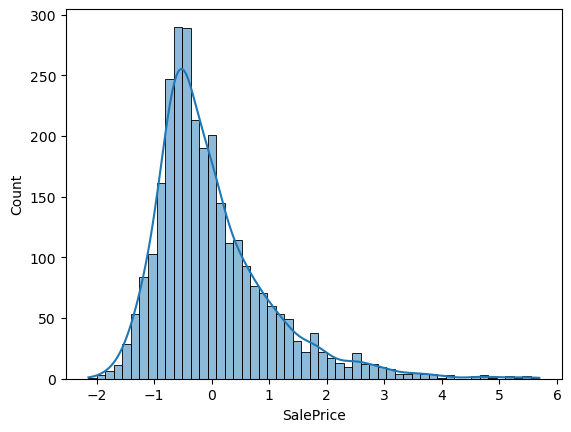

In [5]:
# Plotting Target's distributions and kernel density estimate line
sns.histplot(data.SalePrice, kde=True)
plt.show()

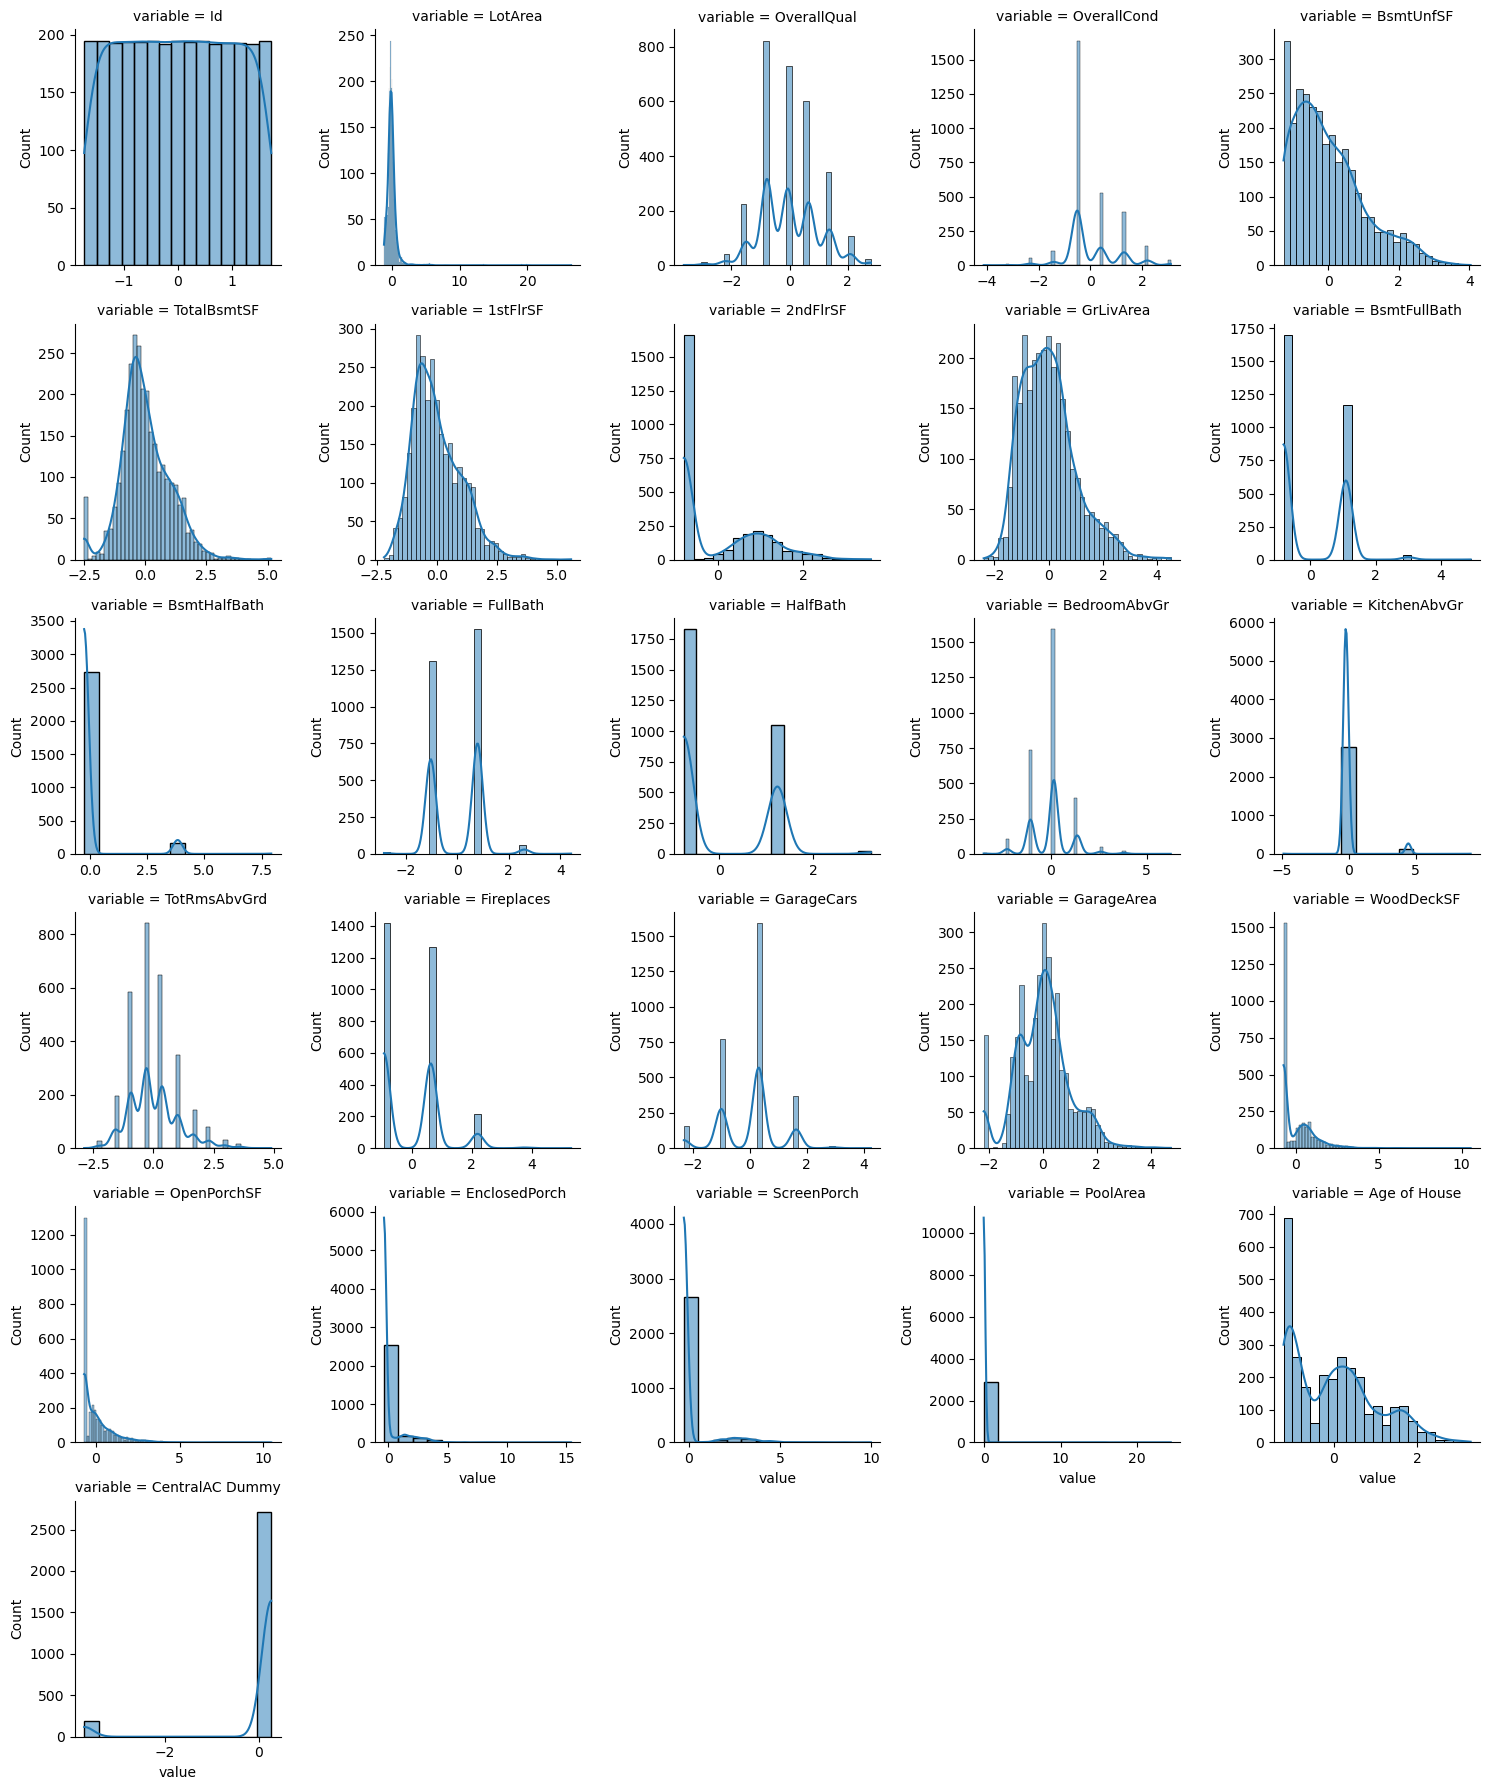

In [6]:
# Plotting featrues' distributions and kernel density estimate line
feature_names = list(features.columns)
features_data = pd.melt(data, value_vars=feature_names)
g = sns.FacetGrid(features_data, col="variable", col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.histplot, "value", kde=True)
plt.show()

## Part A.)  Simple Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression
from scipy import stats

In [8]:
# Perform linear regression
y = data['SalePrice'].array.reshape(-1, 1)
x = features['GrLivArea'].array.reshape(-1, 1)
lr = LinearRegression()
lr.fit(x, y)
pred = lr.predict(x)
r2 = r2_score(y, pred)
print(f'r2 = {r2}')
print(f'Beta = {lr.coef_[0][0]}')

r2 = 0.5211762016616133
Beta = 0.0014912182570222656


In [9]:
# Compute the t-statistic and p-value
params = np.append(lr.intercept_, lr.coef_)
predictions = lr.predict(x)

residuals = y - predictions
RSS = np.sum(residuals ** 2)
MSE = RSS / len(x)

n = len(x)
k = 1  # number of predictors, in this case GrLivArea
dof = n - k - 1  # degrees of freedom

X_with_intercept = np.hstack((np.ones((n, 1)), x))

# Calculate the variance-covariance matrix
XtX_inv = np.linalg.inv(np.matmul(X_with_intercept.T, X_with_intercept))
var_cov_matrix = MSE * XtX_inv

# Extract the standard error for GrLivArea
se_GrLivArea = np.sqrt(var_cov_matrix[1, 1])

# Calculate the t-statistic
t_statistic = params[1] / se_GrLivArea

# Calculate the p-value using the t-distribution CDF
p_value = 2 * (1 - stats.t.cdf(abs(t_statistic), dof))

print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

T-statistic: 56.2505716534538
P-value: 0.0


## Part B.)  Interpretation and Hypothesis Tests

1.R-squared is 0.5211762016616133. 

In this case, an R² of 0.5211 indicates that approximately 52.12% of the variation in SalePrice can be explained by the Above grade living area square feet(GrLiveArea). This means that the model has a moderate explanatory power for predicting SalePrice based on the living area.

---
2.Beta-hat is 0.0014912182570222656. 

It represents the average change in the dependent variable (SalePrice) for a one-unit increase in the standardized independent variable, holding all other variables constant. Economically, this means that for every additional square foot of living area above grade, the SalePrice is expected to increase, on average, by 0.0015 units (**assuming a standardized scale for both variables**).

From an economic perspective, this result may suggest that home buyers are willing to pay more for larger living areas, all else being equal. This could be due to a number of factors, such as increased comfort and convenience, greater flexibility in interior design, or simply a perception of higher quality. 

However, it's important to keep in mind that this is just one possible interpretation, and the true relationship between Above grade living area and Sale Price may be influenced by many other factors that are not included in this model.

---
3.Beta-hat is statistically significant

To determine if Beta-hat is statistically significant, we need to look at the T-statistic and the P-value. In this case, the T-statistic is 56.2505716534538, and the P-value is 0.0. A low P-value (typically below 0.05) indicates that we can reject the null hypothesis, which states that there is no relationship between the dependent and independent variables. Since the P-value is 0.0, we can conclude that Beta-hat is statistically significant. This means that there is strong evidence to suggest that the Above grade living area square feet has a significant impact on the SalePrice.

## Part C.)  Multiple Linear Regression

In [10]:
# define adjusted r2
def adj_r2(n, k, r2):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

In [11]:
# New feature list
features = ['LotArea', 'OverallQual', 'OverallCond', 'Age of House', 'CentralAC Dummy', 'GrLivArea', 'GarageCars']

# Perform multiple linear regression
X = data[features]
y = data['SalePrice']
n, k = x.shape[0], x.shape[1]  # number of predictors
dof = n - k - 1  # degrees of freedom

lr = LinearRegression()
lr.fit(X, y)
pred = lr.predict(X)

# Print r-square and adjusted r-square
r2 = r2_score(y, pred)
print(f'R2: {r2}')
a_r2 = adj_r2(n, k, r2)
print(f'Adj R2: {a_r2}')

R2: 0.8044390109530184
Adj R2: 0.8043716921960316


In [12]:
params = np.append(lr.intercept_, lr.coef_)
predictions = lr.predict(X)

residuals = y - predictions
RSS = np.sum(residuals ** 2)
MSE = RSS / len(X)

X_with_intercept = np.hstack((np.ones((n, 1)), X))

# Calculate the variance-covariance matrix
XtX_inv = np.linalg.inv(np.matmul(X_with_intercept.T, X_with_intercept))
var_cov_matrix = MSE * XtX_inv

# Loop through each feature and calculate its t-statistic and p-value
ste = ['-']
p_value = ['-']
t_statistic = ['-']
for idx, feature in enumerate(features, start=1):
    se = np.sqrt(var_cov_matrix[idx, idx])
    t = params[idx] / se
    p = 2 * (1 - stats.t.cdf(abs(t), dof))
    ste.append(se)
    p_value.append(p)
    t_statistic.append(t)

# Create dataFrame with corresponding feature and its respective coefficients
coeffs = pd.DataFrame(
    {'Coefficient': np.append(lr.intercept_, lr.coef_), 'Standard Error': ste, 'T-statistic': t_statistic,
     'P-value': p_value},
    index=['Intercept'] + features)
print(coeffs)

                  Coefficient Standard Error T-statistic   P-value
Intercept        2.826259e-17              -           -         -
LotArea          1.231051e-01       0.008555   14.389302       0.0
OverallQual      4.084622e-01       0.012911   31.636204       0.0
OverallCond      8.172911e-02       0.009508    8.596063       0.0
Age of House    -2.071308e-01       0.012585  -16.458657       0.0
CentralAC Dummy -1.976012e-02       0.009317   -2.120934  0.034012
GrLivArea        3.606515e-01       0.010902   33.082226       0.0
GarageCars       1.185365e-01       0.011266   10.521757       0.0


## Part D.)  Interpretation

1.The R-squared (R2) value of this regression model is 0.8044390109530184, which indicates that 80.44% of the variance in the dependent variable (SalePrice) can be explained by the independent variables in the model.

The Adjusted R-squared (Adj R2) value is 0.8043716921960316, which is slightly lower than the R2 value. The reason for this is that the Adjusted R-squared takes into account the number of independent variables in the model and adjusts the R-squared accordingly, penalizing for the inclusion of additional variables that do not significantly improve the model's fit.

---
2.The parameter estimates (Beta-hat's) for each of the seven features are as follows:

LotArea: 0.1231051
OverallQual: 0.4084622
OverallCond: 0.08172911
Age of House: -0.2071308
CentralAC Dummy: -0.01976012
GrLivArea: 0.3606515
GarageCars: 0.1185365
To determine which of these coefficients are statistically significant, we can examine their corresponding p-values. In this case, all of the coefficients have p-values less than 0.05, indicating that they are statistically significant at the 5% level.

---
3.The Beta coefficient of Age of House in this regression model can be interpreted as the estimated change in the standardized Sale Price associated with a one-unit increase in the standardized Age of House, holding all other predictors in the model constant.

In this case, if the Beta coefficient of Age of House is -0.2071308, it suggests that a one-unit increase in the **standardized** Age of House is associated with a -0.2071308-unit, on average, decrease in the **standardized** Sale Price, holding all other predictors constant.

From an economic perspective, this result may suggest that home buyers are willing to pay less for older homes, or that older homes may have less value due to depreciation or outdated features.

---
4.The Beta coefficient of Central AC Dummy in this regression model can be interpreted as the estimated change in the standardized Sale Price associated with a one-unit increase in the Central AC Dummy variable (i.e., whether the house has central air conditioning or not), holding all other predictors in the model constant.

In the given regression result, the Beta coefficient of the Central AC Dummy variable is -0.0198, which means that the mean SalePrice of houses with a central air conditioning system (coded as 1) is expected to be 0.0198 units lower, on average, than the mean SalePrice of houses without a central air conditioning system (coded as 0), while controlling for the effects of other predictors in the model.

From an economic standpoint, this could be interpreted as the presence of a central air conditioning system being associated with a lower SalePrice, all other things being equal.

**However**, the regression results are contrary to the actual situation and economic perception. One possible reason for this could be the presence of severe **multicollinearity problems** in the data. Regularization methods such as ***Ridge regression*** and ***Lasso models*** can effectively solve this problem.

## Part E.)  LASSO

In [13]:
# Lasso
from sklearn.linear_model import Lasso

In [14]:
# First 1800 data items are training set; the next 600 are the validation set: the final 508 are the etst set
train = data.iloc[:1800]
val = data.iloc[1800:2400]
test=data.iloc[2400:2908]

X_train, X_val,X_test = train.drop('SalePrice', axis=1), val.drop('SalePrice', axis=1), test.drop('SalePrice', axis=1)
y_train, y_val,y_test = train[['SalePrice']], val[['SalePrice']], test[['SalePrice']]

In [15]:
# Here we produce results for alpha=0.05 which corresponds to lambda=0.1 in Hull's book
lasso = Lasso(alpha=0.05,max_iter=10000000).fit(X_train, y_train)
lasso

Lasso(alpha=0.05, max_iter=10000000)

In [16]:
# DataFrame with corresponding feature and its respective coefficients
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(lasso.intercept_) + list(lasso.coef_)
    ]
).transpose().set_index(0)
coeffs

,1
0,
intercept,-0.009283
Id,-0.0
LotArea,0.039344
OverallQual,0.33599
OverallCond,0.005997
BsmtUnfSF,-0.010107
TotalBsmtSF,0.157952
1stFlrSF,0.03983
2ndFlrSF,0.0


### Lasso with different levels of alpha and its mse

0.13272755730299343
0.13448553742706304
0.13675829289673838
0.13865001149167333
0.14098737942600462
0.1491755181728254
0.15964030083426306


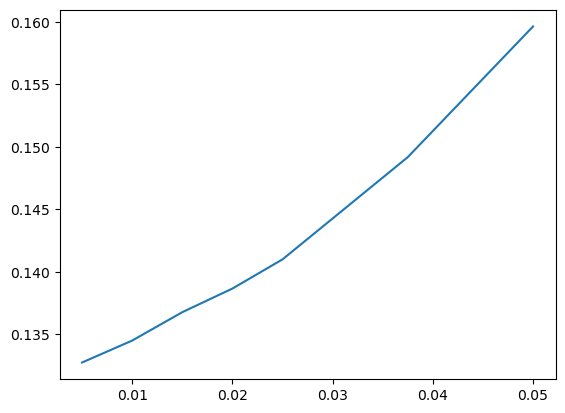

In [17]:
# We now consider different lambda values. The alphas are half the lambdas
alphas=[0.01/2, 0.02/2, 0.03/2, 0.04/2, 0.05/2, 0.075/2, 0.1/2]
mses=[]
for alpha in alphas:
    lasso=Lasso(alpha=alpha,max_iter=10000000)
    lasso.fit(X_train,y_train)
    pred=lasso.predict(X_val)
    mses.append(mse(y_val,pred))
    print(mse(y_val, pred))

plt.plot(alphas, mses)
plt.show()

*The fact that MSE and lambda are positively correlated in Lasso regression indicates that increasing the regularization parameter lambda leads to a decrease in the complexity of the model and an increase in the bias, which can cause an increase in the mean squared error (MSE). In other words, as lambda increases, the Lasso model becomes less prone to overfitting the training data, but may also become less able to capture the true underlying relationship between the predictors and the response variable.*

In [18]:
# Calculate mse for test set when Hull's lambda = 0.04
alpha = 0.04 / 2
lasso = Lasso(alpha = alpha)
lasso.fit(X_train , y_train)
pred = lasso.predict(X_test)
print(mse(y_test , pred))

0.13881182829350164


In [19]:
# Calculate mse for test set when Hull's lambda = 0.1
alpha = 0.1 / 2
lasso = Lasso(alpha = alpha)
lasso.fit(X_train , y_train)
pred = lasso.predict(X_test)
print(mse(y_test , pred))

0.15661817801831446


## Comparison Output of R and Python

By comparing the results of regression analysis in Python and R, there are indeed small differences in R-squared, MSE, and beta coefficients, with differences of approximately 0.0001 units. 

Notes that the lambda and MSE graphs obtained from Python and R are almost identical, both showing a positive correlation, suggests that the two software packages are producing consistent results for the Lasso model. 

It is important to note that these differences may be due to differences in the **algorithms and numerical methods used** in the two software packages, as well as differences in the **default settings and implementation details**. Therefore, it is recommended to carefully examine the code and options used in both Python and R, and choose the one that is most appropriate for the specific analysis being performed. Additionally, it is important to keep in mind the rigor of computer science, statistics, and econometrics when interpreting the results of any regression analysis.